<a href="https://colab.research.google.com/github/ViniciusTavaresSousa/Deteccao-de-Doencas-em-Folhas-de-Soja-com-o-Dataset-ASDID/blob/main/CNN_ASDID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras

#**Modelo**

##**Configurações**

In [97]:
input_shape = (128, 128, 3)
latent_size = 32
batch_size = 32
buffer_size = 5000
epochs = 500

In [98]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

##**Base de Dados**

In [99]:
dataset = np.load("/content/drive/MyDrive/CNN_ASDID/dataset.npy")

x = dataset[:, :, :, :3].astype("float32") / 255.0
y = dataset[:, 0, 0, 3].astype("int")

In [100]:
x.shape, y.shape

((5000, 128, 128, 3), (5000,))

In [101]:
np.max(x), np.min(x), np.max(y), np.min(y)

(np.float32(1.0), np.float32(0.0), np.int64(4), np.int64(0))

In [102]:
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.1),layers.RandomZoom(0.1),layers.RandomContrast(0.1),])

In [103]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=SEED)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size, seed=SEED).batch(batch_size).map(lambda img, label: (data_augmentation(img, training=True), label),num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE))

##**CNN**

In [104]:
def criaCNN():
    entrada = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), strides=(2,2), padding='same')(entrada)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(latent_size)(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    saida = layers.Dense(5, activation='softmax')(x)

    modelo = tf.keras.Model(inputs=entrada, outputs=saida, name="CNN")
    modelo.summary()

    return modelo

In [105]:
cnn = criaCNN()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_64 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_65 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_66 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_67 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_68 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 914,949 (3.49 MB)

 Trainable params: 913,925 (3.49 MB)

 Non-trainable params: 1,024 (4.00 KB)

##**Treinamento**

In [106]:
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, mode='min')

cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cnn.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[early_stopping])

Epoch 1/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.3046 - loss: 1.8738 - val_accuracy: 0.2120 - val_loss: 1.8192
Epoch 2/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.4786 - loss: 1.3092 - val_accuracy: 0.2340 - val_loss: 1.7996
Epoch 3/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.5335 - loss: 1.1634 - val_accuracy: 0.3700 - val_loss: 1.5363
Epoch 4/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.5538 - loss: 1.1143 - val_accuracy: 0.5040 - val_loss: 1.2579
Epoch 5/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.5846 - loss: 1.0703 - val_accuracy: 0.5960 - val_loss: 1.0795
Epoch 6/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.5946 - loss: 1.0597 - val_accuracy: 0.6160 - val_loss: 1.0293
Epoch 7/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.6101 - loss: 0.9999 - val_accuracy: 0.6360 - val_loss: 0.9864
Epoch 8/500
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.6247 -

In [110]:
cnn.save("/content/drive/MyDrive/CNN_ASDID/cnn.keras")

##**Resultados**

In [111]:
cnn = keras.models.load_model("/content/drive/MyDrive/CNN_ASDID/cnn.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


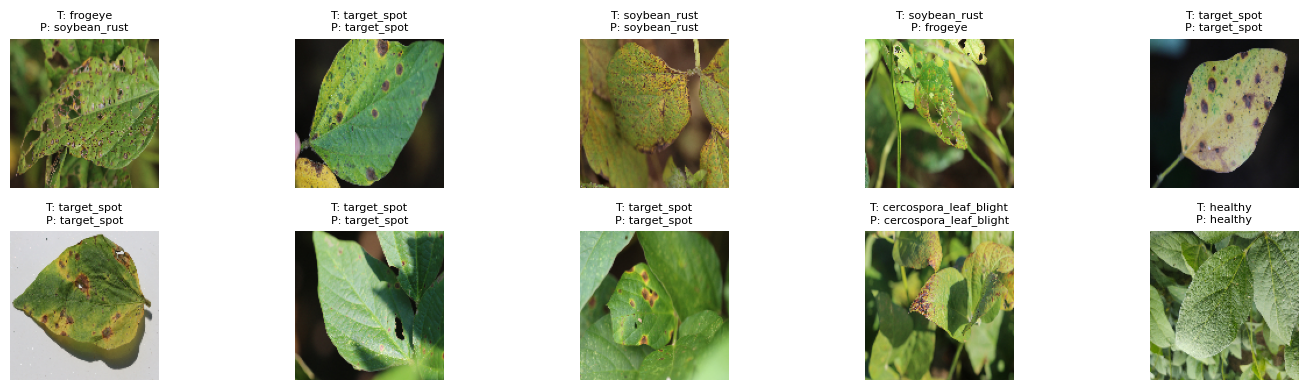

In [112]:
class_names = {
    0: "healthy",
    1: "frogeye",
    2: "cercospora_leaf_blight",
    3: "soybean_rust",
    4: "target_spot"
}

imgs = []
true_labels = []
pred_labels = []

for batch_x, batch_y in val_dataset.take(1):
    preds = cnn.predict(batch_x)
    preds_cls = np.argmax(preds, axis=1)

    imgs.append(batch_x.numpy())
    true_labels.append(batch_y.numpy())
    pred_labels.append(preds_cls)

imgs = np.concatenate(imgs, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

plt.figure(figsize=(15, 4))
for i in range(10):
    img = imgs[i]
    t_label = class_names[int(true_labels[i])]
    p_label = class_names[int(pred_labels[i])]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"T: {t_label}\nP: {p_label}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()